$\#\#\#\#\#\#\#$ Libraries $\#\#\#\#\#\#\#$

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline



import warnings

warnings.filterwarnings('ignore') 

$\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#\#$

# Data

We load the cleaned dataset from Sprint 2, task 5.

In [80]:
df = pd.read_csv('DelayedFlights_Mod.csv')

In [81]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [82]:
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,...,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,VelocityAir,DelayedArr,TotalDelayed,TaxiTime
0,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,...,8.0,0.0,0.0,0.0,0.0,0.0,379.687500,0,0.0,12.0
1,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,...,10.0,0.0,0.0,0.0,0.0,0.0,379.687500,1,0.0,15.0
2,1,3,4,628.0,620,804.0,750,WN,448,N428WN,...,17.0,0.0,0.0,0.0,0.0,0.0,321.875000,1,0.0,20.0
3,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,...,10.0,2.0,0.0,0.0,0.0,32.0,343.333333,1,34.0,13.0
4,1,3,4,1940.0,1915,2121.0,2110,WN,378,N726SW,...,10.0,0.0,0.0,0.0,0.0,0.0,408.712871,1,0.0,14.0


In [83]:
df.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime',
       'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay', 'VelocityAir', 'DelayedArr', 'TotalDelayed',
       'TaxiTime'],
      dtype='object')

Since this exercise belongs to the set from sprint 9, I will not repeating the description of the data, see sprint 9 task 1, for further details [1].

[1] https://github.com/isaura-o/ITAcademia/blob/main/Sprint9/S09T01_Practicant_Train_Test.ipynb

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1928368 entries, 0 to 1928367
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Month              int64  
 1   DayofMonth         int64  
 2   DayOfWeek          int64  
 3   DepTime            float64
 4   CRSDepTime         int64  
 5   ArrTime            float64
 6   CRSArrTime         int64  
 7   UniqueCarrier      object 
 8   FlightNum          int64  
 9   TailNum            object 
 10  ActualElapsedTime  float64
 11  CRSElapsedTime     float64
 12  AirTime            float64
 13  ArrDelay           float64
 14  DepDelay           float64
 15  Origin             object 
 16  Dest               object 
 17  Distance           int64  
 18  TaxiIn             float64
 19  TaxiOut            float64
 20  CarrierDelay       float64
 21  WeatherDelay       float64
 22  NASDelay           float64
 23  SecurityDelay      float64
 24  LateAircraftDelay  float64
 25  VelocityAir       

We need to notice that this dataset has been cleaned apropietly and the columns 25 to 28 are done due the specifications of sprint 2 exercise 5.

# Nivell 1

## Exercici 1: Crea almenys tres models de regressió diferents per intentar predir el millor possible l’endarreriment dels vols (ArrDelay) de DelayedFlights.csv.

To create a model to predict the possibility of delay on flights, first we need to determine which features on the data set are the ones meaningful for the model. To do so, we will purge and modify adequately the features.


From sprint 9 task 1, exercise 3, where we represented the network of the numerical features we have realized that *ArrDelay* belongs to the largest network, connected to air time, different types of delay and taxi. Now, to have a **coarse** insight we will make another time the network, through the correlations model, inserting all variables that are numerical (being categorical or otherwise). 

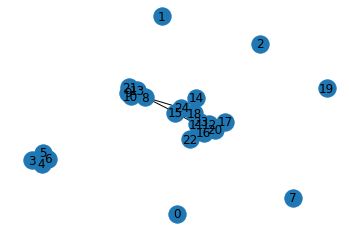

In [6]:
import networkx as nx
dfnum = df[['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime','CRSArrTime',  'FlightNum', 
            'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Distance', 
            'TaxiIn', 'TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 
            'VelocityAir', 'DelayedArr', 'TotalDelayed', 'TaxiTime']]

# 1. get adjacency matrix
corrdf = dfnum.corr()
corrdfas = abs(corrdf)

# 2. Use a threshold to only keep the strongest links:
thres = corrdfas.std()
net = corrdf[(corrdf >= thres) & (corrdf != 1) ] # we don't want self links.
net[np.isnan(net)] = 0
net2 = np.array(net)

# Relabel nodes:
#mapping = dict(zip(G, dfnum.columns.to_list())) # if we want to insert the column name.

# 3. Map the network
G = nx.from_numpy_matrix(net2)

pos = nx.spring_layout(G)
nodes = nx.draw_networkx_labels(G, pos)

nx.draw(G, pos)
plt.show()

In [8]:
dict(zip(G, dfnum.columns.to_list()))

{0: 'Month',
 1: 'DayofMonth',
 2: 'DayOfWeek',
 3: 'DepTime',
 4: 'CRSDepTime',
 5: 'ArrTime',
 6: 'CRSArrTime',
 7: 'FlightNum',
 8: 'ActualElapsedTime',
 9: 'CRSElapsedTime',
 10: 'AirTime',
 11: 'ArrDelay',
 12: 'DepDelay',
 13: 'Distance',
 14: 'TaxiIn',
 15: 'TaxiOut',
 16: 'CarrierDelay',
 17: 'WeatherDelay',
 18: 'NASDelay',
 19: 'SecurityDelay',
 20: 'LateAircraftDelay',
 21: 'VelocityAir',
 22: 'DelayedArr',
 23: 'TotalDelayed',
 24: 'TaxiTime'}

ArrDelay is this case it is the node 11 (list above), as we saw it belongs to the largest network. We see that this node belongs to the largest network, that it is composed by the nodes 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24.

It looks like the categorical variables as Month, DayofMonth, DayOfWeek, with the way they are formated, and, FlightNum are not dependent on the ArrDelay. 

We will analyse a bit further the dates, since the threshold we have imposed to the cross-correlation might have overstimated a bit these fields since we know that sometimes in July/August in airports there are delays and in the northen countries (or in this case on the north of US) snow blizzards and other extrem event cause many of the delays. To do so, we will plot the histograms Month, day, day of week vs DelayedArr column, instead of ArrDelay, that gives us the information if a plane has arrived late or on time.

We will discard Dep/ArrTime and their CRS counterparts, and also SecurityDelay, which is not very correlated with ArrDelay and also we will not lose its information since TotalDelayed is the sum of all the specific delays, this one included.

As last, we will extract from the list the value TaxiTime, since it is just the sum of the variables TaxiIn and TaxiOut, since both are inclded this column is repetive.

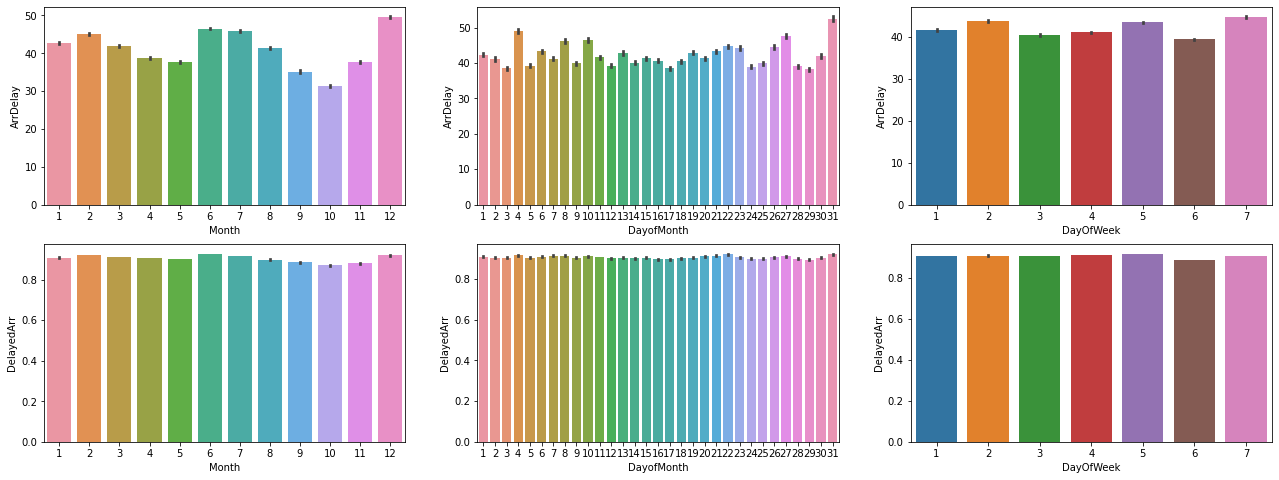

In [12]:
fig, axs = plt.subplots(2,3, figsize=(22,8))
sns.barplot(data=df, x='Month', y='ArrDelay', ax=axs[0,0])
sns.barplot(data=df, x='DayofMonth', y='ArrDelay', ax=axs[0,1])
sns.barplot(data=df, x='DayOfWeek', y='ArrDelay', ax=axs[0,2])
sns.barplot(data=df, x='Month', y='DelayedArr', ax=axs[1,0])
sns.barplot(data=df, x='DayofMonth', y='DelayedArr', ax=axs[1,1])
sns.barplot(data=df, x='DayOfWeek', y='DelayedArr', ax=axs[1,2])
plt.show()

The six graphs show the total delay by month, day of month and day of week, the first row shows the count of minutes of delays from the ArrDelay column (remember this column its values are in minutes, positive for delays, negative for arrived before time, and zero for in time). The second row shows the normalized sum of the delays, since we have been using the column DelayedArr that is binary.

Taking the second row, we can see that the probability of a plane having a delay is around 80%, in every month, day or day of the week. While, the total minutes of delay is what is interesting, while from day to day (DayofMonth and DayOfWeek) it does not vary much, it is always around 40 minutes, some extreme case as the day 31 it is around 50 minutes, in the month the minutes of delay vary quantetively in the non-vacational months, although they are around 50 minutes, specially in October that falls around 30 minutes.

In this case, we will accept the results of our network and discard the dates from the dataset since they do not aport a significative amount of information in the delaying.

The resultant dataset:

In [7]:
df2 = df[['ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Distance', 
            'TaxiIn', 'TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay', 'VelocityAir', 
          'DelayedArr', 'TotalDelayed']]

In [10]:
df2.shape

(1928368, 15)

> Note: Taking out TotalDelayed feature does not change quantetively the result of the predictions. When I have run it without this column, and then run it again with the column SecurityDelay, the results for the squared correlation coefficients (score test) for all three predictors were the same.

> Also, I have run the dataset without the columns DelayedArr, TotalDelayed and **Decision Tree** has determined that the scores of the features are: DepDelay as the most important one (score:0.9), next NAS (0.063), TaxiOur (0.013),  then Carrier and Late Aircraft (0.007), ActualElapsedTime/CRS and Weather (0.003), and finally VelocityAir (0.001). The coefficient of determination obtained for test is: 0.996 and the score for train is: 1.



Now let's use some models to predict the Arrival delays. To do so, first we will need to define our X and our y. The y is the column ArrDelay, since it the one which we wish to train the algorithm for predictions. the X will be all the other columns on df2.

In [8]:
# Define our x and y.
X = np.array(df2.drop('ArrDelay', axis=1))
y = np.array(df2['ArrDelay']).reshape(-1,1)

Split the dataset into train and test[1]:

[1] We will not standarize and normalize the data before, since we want to compute actual minutes.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.3,random_state=42, shuffle=True)

**Linear Regression**

In [17]:
# Linear Regression
mLR = LinearRegression()
mLR.fit(X_train, y_train)

LinearRegression()

In [18]:
print('Coefficient of determination train: {}'.format(mLR.score(X_train, y_train)))
print('Coefficient of determination test: {}'.format(mLR.score(X_test, y_test)))

Coefficient of determination train: 0.9999999979397343
Coefficient of determination test: 0.9999999983780556


In [19]:
print('Coefficients:')
mLR.coef_

Coefficients:


array([-2.46136497e+04, -9.99999149e-01,  2.46146497e+04,  9.99998957e-01,
       -6.34642080e-09,  2.46146497e+04,  2.46146497e+04,  3.13908228e-08,
        9.41876424e-08,  5.51622899e-08,  2.30275870e-07,  3.27081026e-08,
        1.13764155e-05,  9.02749243e-07])

In [20]:
print('Interception with y-axis:')
mLR.intercept_

Interception with y-axis:


-1.722063107933991e-05

In [21]:
# prediction:
ypredLR = mLR.predict(X_test)

In [22]:
df_LR = pd.DataFrame({'Real': y_test, 'Predicted': ypredLR})
df_LR

,Real,Predicted
0,15.0,15.000007
1,9.0,8.999994
2,14.0,13.999994
3,81.0,81.000013
4,19.0,19.000007
...,...,...
578506,96.0,96.000010
578507,118.0,117.999992
578508,7.0,6.999998
578509,-4.0,-4.000001


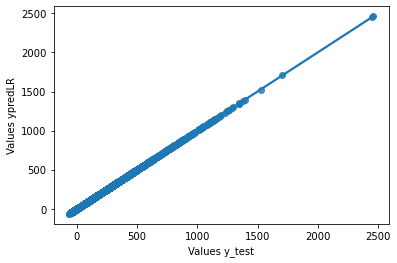

In [20]:
# graph
sns.regplot(data=df_LR, x='Real',y='Predicted')
plt.xlabel('Values y_test')
plt.ylabel('Values ypredLR')
plt.show()

Graph comparing the values predicted vs the values on y_test. We can see that the predicted values are similar to the real ones as shows the determination coefficient given is the $0.99$, the first number different to 9 is up to the 9th decimal for test and 10th decimal for train.

**Decision Tree Regression**

In [23]:
# Decision Tree regressor
mDT = DecisionTreeRegressor(random_state = 42)
mDT.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [24]:
print('number of leaves:')
mDT.get_n_leaves()

number of leaves:


166398

In [25]:
print('Score train: {}'.format(mDT.score(X_train, y_train)))
print('Score test: {}'.format(mDT.score(X_test, y_test)))

Score train: 1.0
Score test: 0.9994801576826828


In [37]:
np.round(mDT.feature_importances_, 3)

array([0.001, 0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.004, 0.993])

The decision tree has determined that the most relevant features ($\geq 0.01$) are: ActualElapsedTime, CRSElapsedTime, DelayedArr and TotalDelay. The last one weight more than the others since contains the information of the delays: carrier, weather, nas, security and lateairplane. DelayedArr is also important since it is a binary column which marks if the plane is late or not.

In [26]:
ypredDT = mDT.predict(X_test)

In [27]:
df_DT = pd.DataFrame({'Real': y_test, 'Predicted': ypredDT})
df_DT

,Real,Predicted
0,15.0,15.0
1,9.0,9.0
2,14.0,12.0
3,81.0,81.0
4,19.0,19.0
...,...,...
578506,96.0,96.0
578507,118.0,118.0
578508,7.0,7.0
578509,-4.0,-4.0


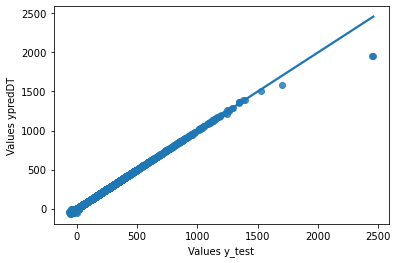

In [26]:
# graph
sns.regplot(data=df_DT, x='Real',y='Predicted')
plt.xlabel('Values y_test')
plt.ylabel('Values ypredDT')
plt.show()

Graph comparing the values predicted vs the values in y_test. We can see that the fit is mostly perfect, but some value, the largest ones are the ones with more variation, seems that this model is good for small values but fails to predict correctly for larger ones. 

We can notice, that the larger values correspond to larger delay times, which maybe correspond to extreme weather events, in the dataset may not be enough data to predict them correctly as the others has been predicted.

The determination coefficient for test was $0.9994$ which is considered an acceptable prediction.

**Random Forest Regression**

In [28]:
# Random Forest regression
mRF = RandomForestRegressor(n_estimators= 100, random_state=42, n_jobs=-1)
mRF.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [29]:
print('Score train: {}'.format(mRF.score(X_train, y_train)))
print('Score test: {}'.format(mRF.score(X_test, y_test)))

Score train: 0.9999815661230922
Score test: 0.9993178259741085


In [30]:
ypredRF = mRF.predict(X_test)

In [31]:
df_RF = pd.DataFrame({'Real': y_test, 'Predicted': ypredRF})
df_RF

,Real,Predicted
0,15.0,15.00
1,9.0,9.34
2,14.0,11.27
3,81.0,81.00
4,19.0,19.00
...,...,...
578506,96.0,96.00
578507,118.0,118.00
578508,7.0,7.19
578509,-4.0,-3.99


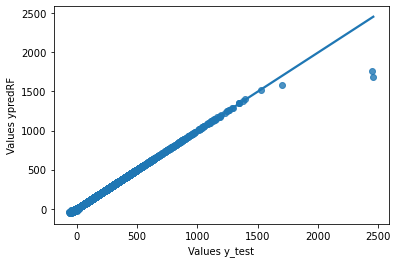

In [31]:
sns.regplot(data=df_RF, x='Real',y='Predicted')
plt.xlabel('Values y_test')
plt.ylabel('Values ypredRF')
plt.show()

For this regressor, graphically, we find that similar results to the Decision Tree, that for larger values this predictor cannot predict that well the values, and the determination coefficient in the test is $0.9993$, which is a high overall score, thus the prediction is accepted. If we look at the table above the graph we can see that some of the values, small values, that differ from the real ones its difference up to the first/second decimal.

## Exercici 2: Compara’ls en base al MSE i al R2 .

This exercise asks us to compute the mean squared error and the correlation coefficient (squared) (which on sklearn they call it determination coefficient, but it is the correlation coeficient) to determine how well behaved are our models.

MSE is the mean squared value of the error.

$$MSE = \frac{1}{N}\sum_{i=1}^{N} (y_i - \hat{y}_i)^2$$

where N is number of samples, $y_i$ are the real values and $\hat{y}_i$ are the predicted values.

In [32]:
# MSE Comparation:
print('Mean Square Error for LinearRegression: {}'.format(metrics.mean_squared_error(y_test, ypredLR)))
print('Mean Square Error for DecisionTree: {}'.format(metrics.mean_squared_error(y_test, ypredDT)))
print('Mean Square Error for RandomForest: {}'.format(metrics.mean_squared_error(y_test, ypredRF)))

Mean Square Error for LinearRegression: 5.185737867974626e-06
Mean Square Error for DecisionTree: 1.6620582841121432
Mean Square Error for RandomForest: 2.181070977042788


We also run, even the exercise is not asking it for, the Mean Absolute Error. This will tell us how bad the model is doing in predictions, since it is the expected value of the absolute error (difference between y_val_real and y_calculated in absolute values).

$$MAE = \frac{1}{N}\sum_{i=1}^{N} |y_i - \hat{y}_i |$$


In [100]:
# MAE Comparation:
print('Mean Absolute Error for LinearRegression: {}'.format(metrics.mean_absolute_error(y_test, ypredLR)))
print('Mean Absolute Error for DecisionTree: {}'.format(metrics.mean_absolute_error(y_test, ypredDT)))
print('Mean Absolute Error for RandomForest: {}'.format(metrics.mean_absolute_error(y_test, ypredRF)))

Mean Absolute Error for LinearRegression: 1.1366079239846395e-05
Mean Absolute Error for DecisionTree: 0.23679930027259638
Mean Absolute Error for RandomForest: 0.15324967027420391


$R^2$ it is, also, an **external cross validation method**. External cross validation is obtained from running an avaluation function like accuracy or $R^2$ score functions with the values obtained from the splitting of the data set only in train/test, train the model with training set and predict the values for the test set.

Now we will compute this score for each one of the methods used in exercise 1. We will use the function r2_score (which instead compares the score between the y test and predicted), since we are only interested with on how well have behave the model in predicting the data compared with test data:

In [38]:
# R^2:
print('R^2 for LinearRegression: {}'.format(metrics.r2_score(y_test, ypredLR)))
print('R^2 for DecisionTree: {}'.format(metrics.r2_score(y_test, ypredDT)))
print('R^2 for RandomForest: {}'.format(metrics.r2_score(y_test, ypredRF)))

R^2 for LinearRegression: 0.9999999983780556
R^2 for DecisionTree: 0.9994801576826828
R^2 for RandomForest: 0.9993178259741085


Since our predictors had been well behaved (see graphs on exercise 1) on their predictions we obtain very low values for the MSE and nearly 1 values for the $R^2$ score.

To determine how good has our data has been predicted, we cannot run the confusion matrix, since it serves for validation of data binary or categorical. Another tool to examine if our model is being overfitted is by using the cross-validate function, we will use this one in exercise 4, since it is used for internal avaluations as it is asked to do.

## Exercici 3: Entrena’ls utilitzant els diferents paràmetres que admeten.

This exercise is to repeat the exercise 1, but instead change the default parameters on the regressors that we have used.

**Linear Regression**

For this model we can change only two parameters: fit_intercept and normalization.

Fit_intercept in false asumes that the data is centered, in True (default) it centers the data.

In [12]:
# we will also use the parallel option :)
inter = [False, True]
normi = [False, True]

MAEtrain_lr = []
MAEpre_lr = []

Strain_lr = []
Stest_lr = []

for i in inter:
    for j in normi:
        lr = LinearRegression(fit_intercept=i, normalize=j, n_jobs=-1)
        lr.fit(X_train, y_train)
        
        ylr = lr.predict(X_train)
        MAEtrain_lr.append(metrics.mean_absolute_error(y_train, ylr))
        Strain_lr.append(lr.score(X_train, y_train))
        
        yplr = lr.predict(X_test)
        MAEpre_lr.append(metrics.mean_absolute_error(y_test, yplr))
        Stest_lr.append(lr.score(X_test, y_test))

print('MAE train: ', MAEtrain_lr)
print('Score train: ', Strain_lr) 
print('MAE test: ', MAEpre_lr)
print('Score test: ', Stest_lr)


MAE train:  [1.2556177322160607e-05, 1.2556177322160607e-05, 1.2865729792308234e-05, 1.2863313689844415e-05]
Score train:  [0.9999999979397332, 0.9999999979397332, 0.9999999979397343, 0.9999999979397343]
MAE test:  [1.105786358645447e-05, 1.105786358645447e-05, 1.1366079239846395e-05, 1.1363662749728472e-05]
Score test:  [0.9999999983780544, 0.9999999983780544, 0.9999999983780556, 0.9999999983780556]


In [72]:
dfp_lr = pd.DataFrame({'Train MAE': MAEtrain_lr, 'Test MAE': MAEpre_lr, 'Train Score': Strain_lr, 'Test Score' : 
                       Stest_lr}, index=['False/False', 'False/True', 'True/False', 'True/True'])
dfp_lr

,Train MAE,Test MAE,Train Score,Test Score
False/False,0.000013,0.000011,1.0,1.0
False/True,0.000013,0.000011,1.0,1.0
True/False,0.000013,0.000011,1.0,1.0
True/True,0.000013,0.000011,1.0,1.0


**Decision Tree Regressor**

Since we have some parameters that can be inserted by hand, like max_depth, min_samples_split, min_samples_leaf, and max_features. We will use loops to run some values and see how the squared correlation behave.

We leave the criterion as MSE (default), instead of MAE, and we cannot use Poisson criterion since we have some negative values on the y.

In [25]:
# changing: max_depth:

depth = list(range(1,25+1))

MAEtrain_dt = []
MAEpre_dt = []

for i in depth:
        dt = DecisionTreeRegressor(random_state=42, max_depth=i)
        dt.fit(X_train, y_train)
        
        ydt = dt.predict(X_train)
        MAEtrain_dt.append(metrics.mean_absolute_error(y_train, ydt))
        
        ypdt = dt.predict(X_test)
        MAEpre_dt.append(metrics.mean_absolute_error(y_test, ypdt))


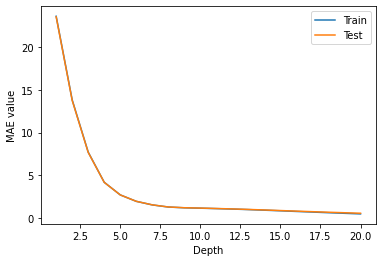

In [26]:
# plot the MAE vs the max_depth, for test and for train:
line1 = plt.plot(depth, MAEtrain_dt)
line2 = plt.plot(depth, MAEpre_dt)
plt.xlabel('Depth')
plt.ylabel('MAE value')
plt.legend(['Train', 'Test'])
plt.show()

As the depth increases the MAE value decrases, so we use as high depth values to reduce the error, since the plateau begins around depth 10 we can take one value larger than this one as our depth. 

In [18]:
# changing: min_samples_split: The allowed range is (0, 1].

splot = np.linspace(0.1, 1, 10, endpoint=True)

MAEtrain_dt = []
MAEpre_dt = []

for i in splot:
    dt = DecisionTreeRegressor(random_state = 42, min_samples_split=i)
    dt.fit(X_train, y_train)
        
    ydt = dt.predict(X_train)
    MAEtrain_dt.append(metrics.mean_absolute_error(y_train, ydt))
        
    ypdt = dt.predict(X_test)
    MAEpre_dt.append(metrics.mean_absolute_error(y_test, ypdt))

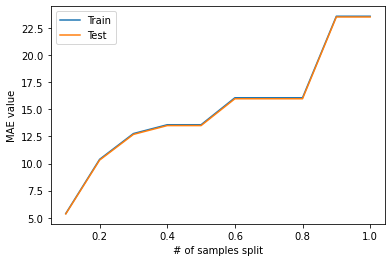

In [19]:
# plot the MAE vs the number of samples split, for test and for train:
line1 = plt.plot(splot, MAEtrain_dt)
line2 = plt.plot(splot, MAEpre_dt)
plt.xlabel('# of samples split')
plt.ylabel('MAE value')
plt.legend(['Train', 'Test'])
plt.show()

As the number of samples split increases the error also increases, we will leave this parameter to default.

In [20]:
# changing: min_samples_leaf: The compilator says the range is (0, 0.5].

leaves = np.linspace(0.01,0.5,20, endpoint=True)

MAEtrain_dt = []
MAEpre_dt = []

for i in leaves:
    dt = DecisionTreeRegressor(random_state = 42, min_samples_leaf=i)
    dt.fit(X_train, y_train)
        
    ydt = dt.predict(X_train)
    MAEtrain_dt.append(metrics.mean_absolute_error(y_train, ydt))
        
    ypdt = dt.predict(X_test)
    MAEpre_dt.append(metrics.mean_absolute_error(y_test, ypdt))

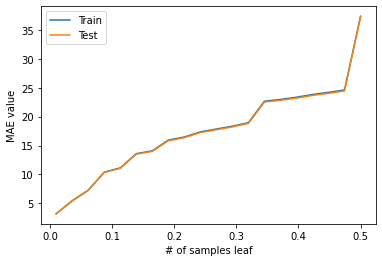

In [21]:
# plot the MAE vs the number of samples leaf, for test and for train:
line1 = plt.plot(leaves, MAEtrain_dt)
line2 = plt.plot(leaves, MAEpre_dt)
plt.xlabel('# of samples leaf')
plt.ylabel('MAE value')
plt.legend(['Train', 'Test'])
plt.show()

The same as the last, the error increases as the number of samples on the leaf increase. We will keep this parameter at default.

In [22]:
# changing: max_features: we need at least 2 features to began a regression.

feats = list(range(2,X.shape[1]+1))

MAEtrain_dt = []
MAEpre_dt = []

for i in feats:
    dt = DecisionTreeRegressor(random_state = 42, max_features=i)
    dt.fit(X_train, y_train)
        
    ydt = dt.predict(X_train)
    MAEtrain_dt.append(metrics.mean_absolute_error(y_train, ydt))
        
    ypdt = dt.predict(X_test)
    MAEpre_dt.append(metrics.mean_absolute_error(y_test, ypdt))

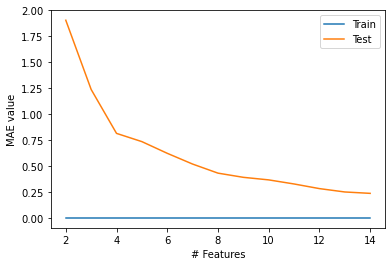

In [99]:
# plot the MAE vs the number of features, for test and for train:
line1 = plt.plot(feats, MAEtrain_dt)
line2 = plt.plot(feats, MAEpre_dt)
plt.xlabel('# Features')
plt.ylabel('MAE value')
plt.legend(['Train', 'Test'])
plt.show()

Increasing the number of features decreases the Mean Absolute Error, thus the y predicted is more finer as more features are added. To obtain maximum efficency in this parameter we will set the number of features to default, that option takes all the features on the dataset.

*Summary*: We will leave on default all the variables but max_depth that will be set up at 10.

**Random Forest Regressor**

To do the study for estimating the MAE of the parameters, in this case, since RandomForestRegressor is very time consuming for datasets big as this one, we will split the training set into training and test.

In [14]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, 
                                                        test_size=0.3,random_state=42, shuffle=True)

In [15]:
X_train2.shape

(944899, 14)

In [16]:
X_test2.shape

(404958, 14)

We will tune the same parameters as before, but now also we add the n_estimators parameter.

In [ ]:
# changing n_estimators (for this dataset less than 1000!)

ests = list(range(100,700,100))#[100,200,300]

MAEtrain_rf = []
MAEpre_rf = []

for i in ests:
    rf = RandomForestRegressor(n_estimators=i, random_state = 42, n_jobs=-1)
    rf.fit(X_train2, y_train2)
        
    yrf = rf.predict(X_train2)
    MAEtrain_rf.append(metrics.mean_absolute_error(y_train2, yrf))
        
    yprf = rf.predict(X_test2)
    MAEpre_rf.append(metrics.mean_absolute_error(y_test2, yprf))
    #print(i)

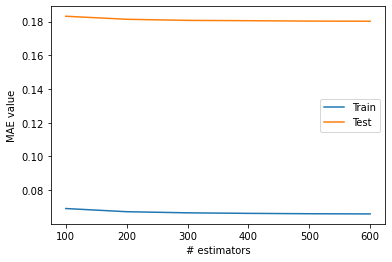

In [20]:
# plot the MAE vs the number of estimators, for test and for train:
line1 = plt.plot(ests, MAEtrain_rf)
line2 = plt.plot(ests, MAEpre_rf)
plt.xlabel('# estimators')
plt.ylabel('MAE value')
plt.legend(['Train', 'Test'])
plt.show()

There is not variation in the error of 100 estimators compared to 600 estimators, the graph shows a plateau. We will use 100 estimators.

In [18]:
# changing max_depth

depth = np.linspace(1,20, 10)

MAEtrain_rf = []
MAEpre_rf = []

for i in depth:
    rf = RandomForestRegressor(n_estimators=100, max_depth=i, random_state = 42, n_jobs=-1)
    rf.fit(X_train2, y_train2)
        
    yrf = rf.predict(X_train2)
    MAEtrain_rf.append(metrics.mean_absolute_error(y_train2, yrf))
        
    yprf = rf.predict(X_test2)
    MAEpre_rf.append(metrics.mean_absolute_error(y_test2, yprf))

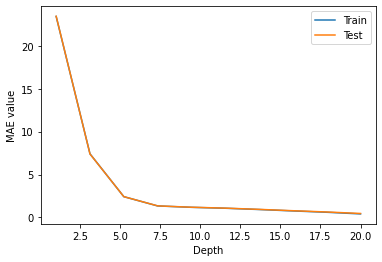

In [19]:
# plot the MAE vs the number of estimators, for test and for train:
line1 = plt.plot(depth, MAEtrain_rf)
line2 = plt.plot(depth, MAEpre_rf)
plt.xlabel('Depth')
plt.ylabel('MAE value')
plt.legend(['Train', 'Test'])
plt.show()

Increasing the depth the error decreases, so big values give less error than small ones. We will use depth=20.

In [22]:
# changing: min_samples_split: The allowed range is (0, 1].

splot = np.linspace(0.1, 1, 10, endpoint=True)

MAEtrain_rf = []
MAEpre_rf = []

for i in splot:
    rf = RandomForestRegressor(n_estimators=100, min_samples_split=i, random_state = 42, n_jobs=-1)
    rf.fit(X_train2, y_train2)
        
    yrf = rf.predict(X_train2)
    MAEtrain_rf.append(metrics.mean_absolute_error(y_train2, yrf))
        
    yprf = rf.predict(X_test2)
    MAEpre_rf.append(metrics.mean_absolute_error(y_test2, yprf))

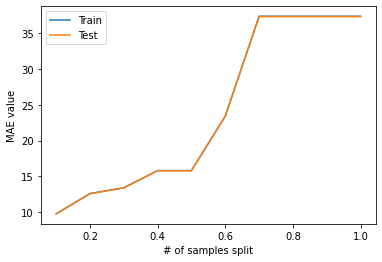

In [23]:
# plot the MAE vs the number of samples split, for test and for train:
line1 = plt.plot(splot, MAEtrain_rf)
line2 = plt.plot(splot, MAEpre_rf)
plt.xlabel('# of samples split')
plt.ylabel('MAE value')
plt.legend(['Train', 'Test'])
plt.show()

Error increases as we increase the minimum of samples to split, thus we will be using the default value given for the function.

In [31]:
# changing: min_samples_leaf: The compilator says the range is (0, 0.5].

leaves = np.linspace(0.01,0.5,10, endpoint=True)

MAEtrain_rf = []
MAEpre_rf = []

for i in leaves:
    rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=i, random_state = 42, n_jobs=-1)
    rf.fit(X_train2, y_train2)
        
    yrf = rf.predict(X_train2)
    MAEtrain_rf.append(metrics.mean_absolute_error(y_train2, yrf))
        
    yprf = rf.predict(X_test2)
    MAEpre_rf.append(metrics.mean_absolute_error(y_test2, yprf))

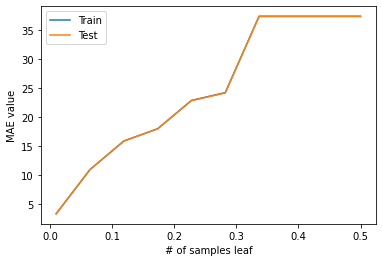

In [32]:
# plot the MAE vs the number of samples on leaf, for test and for train:
line1 = plt.plot(leaves, MAEtrain_rf)
line2 = plt.plot(leaves, MAEpre_rf)
plt.xlabel('# of samples leaf')
plt.ylabel('MAE value')
plt.legend(['Train', 'Test'])
plt.show()

Increasing the minimum of samples in each leaf, increases the error, then we will be using the default value for this parameter.

In [28]:
# changing: max_features: we need at least 2 features to began a regression.

feats = list(range(2,X.shape[1]+1))

MAEtrain_rf = []
MAEpre_rf = []

for i in feats:
    rf = RandomForestRegressor(n_estimators=100, max_features=i, random_state = 42, n_jobs=-1)
    rf.fit(X_train2, y_train2)
        
    yrf = rf.predict(X_train2)
    MAEtrain_rf.append(metrics.mean_absolute_error(y_train2, yrf))
        
    yprf = rf.predict(X_test2)
    MAEpre_rf.append(metrics.mean_absolute_error(y_test2, yprf))

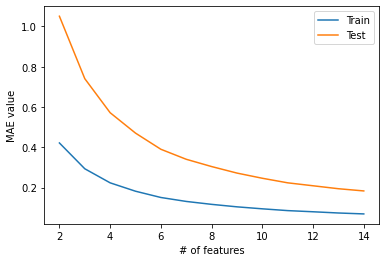

In [29]:
# plot the MAE vs max of features for test and for train:
line1 = plt.plot(feats, MAEtrain_rf)
line2 = plt.plot(feats, MAEpre_rf)
plt.xlabel('# of features')
plt.ylabel('MAE value')
plt.legend(['Train', 'Test'])
plt.show()

In the graph we can see that when we increase the number of features the mean absolute error decresases, thus we will use all features avaible.

*Summary*: For RandomForestRegressor the best parameters are: n_estimators = 100, max_depth = 20, and, all features. 
For the other parameters will be using the default values. Also, we will be using the potion parallel computing, to use all 8 CPU kernels on my computer.

## Exercici 4: Compara el seu rendiment utilitzant l’aproximació traint/test o utilitzant totes les dades (validació interna)

We compile the external and internal validations by using the parameters computed on the last exercise.

**External cross validation**. As we have pointed in exercise 2, external crossvalidation is done after we have split the dataset in train/test, we have trained our model with train data, and produced the prediction set. Then the accuracy or score ($R^2$) functions will give us how well behaved is model, its score (1 for well behaved, -1 if it is arbitrarly worse ($R^2$ case) or 0 if the model disregards the input values).

In [35]:
# Linear Regression
cmLR = LinearRegression(normalize=True, n_jobs=-1) #fit_intercept is already on True
cmLR.fit(X_train, y_train)

print('train score:', cmLR.score(X_train, y_train))
print('test score:', cmLR.score(X_test, y_test))

train score: 0.9999999979397343
test score: 0.9999999983780556


The scores are the same we had obtained without using the normalization. For this system, the prediction will be same as without using the normalization.

In [36]:
# Decision Tree Regressor
cmDT = DecisionTreeRegressor(random_state=42, max_depth=20)
cmDT.fit(X_train,y_train)

print('train score:', cmDT.score(X_train, y_train))
print('test score:', cmDT.score(X_test, y_test))

train score: 0.9993475535562285
test score: 0.998936130259752


The model with max depth of 20 predicts worse than when it was default. The score before was: train -> 1, test -> 0.9995. By setting the parameter max_depth to 20, the score has decrease slightly, even though the model is well behaved on its predictions.

In [40]:
cmRF = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=20, n_jobs=-1)
cmRF.fit(X_train, y_train)

print('train score:', cmRF.score(X_train, y_train))
print('test score:', cmRF.score(X_test, y_test))

train score: 0.9995228593395411
test score: 0.9988914225156289


In this case, the model with depth = 20, has less coefficient of determination, $R^2$ score. Before: train was: $0.99998$ and now it is $0.9995$; for test: $0.9998$ and now it is $0.999$. Even though the difference in the score the model behaves and the predicted y will give similar results to the ones found without setting a value on max_depth.

**Internal cross validation** We will split the dataset (full) in five folds and avalute them respect the models used. To do so, we will use the function cross_validate from model_selection library.

In [29]:
# cross-validation LR with cv=5 (five-fold standard)
cmLR = make_pipeline(StandardScaler(), LinearRegression()) # not accept normalization from the model, needs pipline
cvLR = cross_validate(cmLR, X, y, n_jobs=-1)
print('keys LR:{}'.format(sorted(cvLR.keys())))
print('test scores LR: {}'.format(cvLR['test_score']))

keys LR:['fit_time', 'score_time', 'test_score']
test scores LR: [0.99999999 1.         1.         1.         1.        ]


In [30]:
# cross-validation DT with cv=5 (five-fold standard)
cvDT = cross_validate(cmDT, X, y, n_jobs=-1)
print('keys DT:{}'.format(sorted(cvDT.keys())))
print('test scores DT: {}'.format(cvDT['test_score']))

keys DT:['fit_time', 'score_time', 'test_score']
test scores DT: [0.99913691 0.99896893 0.99923703 0.99923063 0.99921107]


In [15]:
# cross-validation RF with cv=5 (five-fold standard)
cvRF = cross_validate(cmRF, X, y.ravel(), n_jobs=-1)
print('keys:{}'.format(sorted(cvRF.keys())))
print('test scores: {}'.format(cvRF['test_score']))

keys:['fit_time', 'score_time', 'test_score']
test scores: [0.99930372 0.99924819 0.99937561 0.99945155 0.99945939]


In [32]:
print('difference between the values for LR:', abs(np.diff(cvLR['test_score'])))
print('difference between the values for DT:', abs(np.diff(cvDT['test_score'])))
print('difference between the values for RF:', abs(np.diff(cvRF['test_score'])))

difference between the values for LR: [9.80251635e-09 1.11022302e-16 2.99760217e-15 9.99200722e-16]
difference between the values for DT: [1.67972873e-04 2.68092554e-04 6.40055342e-06 1.95563708e-05]
difference between the values for RF: [5.55335614e-05 1.27419302e-04 7.59421917e-05 7.84016112e-06]


In [43]:
print('difference between the values for LR full and test:', abs(cvLR['test_score'] - cmLR1.score(X_test, y_test)))
print('difference between the values for DT full and test:', abs(cvDT['test_score'] - cmDT1.score(X_test,y_test)))
print('difference between the values for RF full and test:', abs(cvRF['test_score'] - cmRF1.score(X_test,y_test)))

difference between the values for LR full and test: [8.18059509e-09 1.62192126e-09 1.62192137e-09 1.62192437e-09
 1.62192337e-09]
difference between the values for DT full and test: [2.00777488e-04 3.28046147e-05 3.00897169e-04 2.94496615e-04
 2.74940244e-04]
difference between the values for RF full and test: [0.0004123  0.00035677 0.00048419 0.00056013 0.00056797]


> Note: if you are following the code the values cmLR1/DT1/RF1 has been compiled by changing the values to this ones on the external cross validation, and then executed. Afterwards, we decided to leave the values as should have been without doing the analysis. 

> Note2: The differences between values are done with the function diff that works by doing the difference of the value: $[(i+1) - i]$. This is why we only get 4 values, for doing all against all we need to do a loop, but in this case since the test scores are very similar we do not need to go into more detail.

The internal cross validation in the three cases gives for the 5 folds similar scores to each, we can see that its differences, the bigger ones are of $10^{-4}$, also, we notice that these scores are also similars to the scores obtained for the external cross-validation. The scores that perform that are more different are the ones computed via RandomForest (difference of $10^{-4}$) while the more accurate ones are the ones computed by the linear regression.

# Nivell 2

## Exercici 5: Realitza algun procés d’enginyeria de variables per millorar-ne la predicció

The first transformation in our dataset will be doing a polar transformation on the dates, in order to have the dates in cyclic manner. The polar transformation is:

$$ \mbox{date_cos} = cos\left( 2\pi \frac{x_i}{N} \right)$$
$$ \mbox{date_sin} = sin\left( 2\pi \frac{x_i}{N} \right)$$

where $x_i$ are each single values of the feature we want to make cyclic: months, days, day of the week; and N is the total numbers of months, days and days of the week (N = 12, 31, 7 respectively).

The second transformation we will apply to make the date cyclic will be done by using 10 base multiplication and sum on the dates, also, we can add the DepTime/CRSDepTime/ArrTime/CRSArrTime columns to make it more complete, as it follows:

1. In our dataset the times are in format HHMM (see DepTime column as example), so this is the base.
2. Multiply by $10^4$ the DayofMonth, since time has 4 integers.
3. Multiply Month by $10^6$, since days can have two integers (DD).
4. Multiply Year by $10^8$, since months also have two integers (MM).

The last one is optional, but if we want to transform the data with the built-in function like timedate/timestamp of pandas to split the data afterwards it is useful to know the year if we want information as the dayOfWeek (Mon-Sun), as it is on our dataset. After this transformation we can also drop the column dayOfWeek, since it is implicit on the "time-epoch" we have created.

In [84]:
# 1. Transforming the data to polar coordinates 
# CAUTION! the daysofMonth will be wrong since we take all months with 31 days
df['Mcos'] = np.cos(2*np.pi*df.Month / df.Month.nunique())
df['Msin'] = np.sin(2*np.pi*df.Month / df.Month.nunique())

df['Dcos'] = np.cos(2*np.pi*df.DayofMonth / df.DayofMonth.nunique())
df['Dsin'] = np.sin(2*np.pi*df.DayofMonth / df.DayofMonth.nunique())

df['Wcos'] = np.cos(2*np.pi*df.DayOfWeek / df.DayOfWeek.nunique())
df['Wsin'] = np.sin(2*np.pi*df.DayOfWeek / df.DayOfWeek.nunique())

df.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,...,VelocityAir,DelayedArr,TotalDelayed,TaxiTime,Mcos,Msin,Dcos,Dsin,Wcos,Wsin
0,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,...,379.687500,0,0.0,12.0,0.866025,0.5,0.820763,0.571268,-0.900969,-0.433884
1,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,...,379.687500,1,0.0,15.0,0.866025,0.5,0.820763,0.571268,-0.900969,-0.433884
2,1,3,4,628.0,620,804.0,750,WN,448,N428WN,...,321.875000,1,0.0,20.0,0.866025,0.5,0.820763,0.571268,-0.900969,-0.433884
3,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,...,343.333333,1,34.0,13.0,0.866025,0.5,0.820763,0.571268,-0.900969,-0.433884
4,1,3,4,1940.0,1915,2121.0,2110,WN,378,N726SW,...,408.712871,1,0.0,14.0,0.866025,0.5,0.820763,0.571268,-0.900969,-0.433884


In [85]:
# 2. Transforming data in cyclic for timestamp/timedate built-in functions.
# we make use of the columns DepTime, CRSDepTime, ArrTime, CRSArrTime to know the hours for the date transformation.
# we can notice that afterwards we can drop these columns.
df['Year'] = 2008 # we add the column of year, previously erased, will be dropped afterwards.
df['DateDep'] = df.DepTime + df.DayofMonth*10000 + df.Month*1000000 + df.Year*100000000
df['DateCRSDep'] = df.CRSDepTime + df.DayofMonth*10000 + df.Month*1000000 + df.Year*100000000
df['DateArr'] = df.ArrTime + df.DayofMonth*10000 + df.Month*1000000 + df.Year*100000000
df['DateCRSArr'] = df.CRSArrTime + df.DayofMonth*10000 + df.Month*1000000 + df.Year*100000000

df.tail()
# we can see that these columns are in format "time-epoch" and also they are treatable by timedate functions!
# Also, they are integers, that might help to feed into models, if they are required on the analysis.

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,...,Msin,Dcos,Dsin,Wcos,Wsin,Year,DateDep,DateCRSDep,DateArr,DateCRSArr
1928363,12,13,6,1250.0,1220,1617.0,1552,DL,1621,N938DL,...,-2.449294e-16,-0.874347,0.485302,0.62349,-0.781831,2008,2.008121e+11,200812131220,2.008121e+11,200812131552
1928364,12,13,6,657.0,600,904.0,749,DL,1631,N3743H,...,-2.449294e-16,-0.874347,0.485302,0.62349,-0.781831,2008,2.008121e+11,200812130600,2.008121e+11,200812130749
1928365,12,13,6,1007.0,847,1149.0,1010,DL,1631,N909DA,...,-2.449294e-16,-0.874347,0.485302,0.62349,-0.781831,2008,2.008121e+11,200812130847,2.008121e+11,200812131010
1928366,12,13,6,1251.0,1240,1446.0,1437,DL,1639,N646DL,...,-2.449294e-16,-0.874347,0.485302,0.62349,-0.781831,2008,2.008121e+11,200812131240,2.008121e+11,200812131437
1928367,12,13,6,1110.0,1103,1413.0,1418,DL,1641,N908DL,...,-2.449294e-16,-0.874347,0.485302,0.62349,-0.781831,2008,2.008121e+11,200812131103,2.008121e+11,200812131418


We will use the function label encoder, so we can add the categories UniqueCarrier, Origin, Destination, and, TailNum. Sometimes, there are companies more prone to delays, and also some destinations have more delayed planes than others and we want to see if these columns are relevant on our dataset.

We use LabelEncoder instead of get_dummies, since it doesn't create a feature for each unique variable, instead it codifies each unique variable with numbers from 0 to the sum of all unique values minus 1 (nunique() -1), i.e., the range (or domain of a variable).

In [86]:
encode = LabelEncoder()
df['UCarrier_en'] = encode.fit_transform(df['UniqueCarrier'])
df['Origin_en'] = encode.fit_transform(df['Origin'])
df['Dest_en'] = encode.fit_transform(df['Dest'])
df['TailNum_en'] = encode.fit_transform(df['TailNum'])
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,...,Wsin,Year,DateDep,DateCRSDep,DateArr,DateCRSArr,UCarrier_en,Origin_en,Dest_en,TailNum_en
0,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,...,-0.433884,2008,2.008010e+11,200801031955,2.008010e+11,200801032225,17,135,284,3756
1,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,...,-0.433884,2008,2.008010e+11,200801030735,2.008010e+11,200801031000,17,135,284,4116
2,1,3,4,628.0,620,804.0,750,WN,448,N428WN,...,-0.433884,2008,2.008010e+11,200801030620,2.008010e+11,200801030750,17,140,48,1948
3,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,...,-0.433884,2008,2.008010e+11,200801031755,2.008010e+11,200801031925,17,140,48,2129
4,1,3,4,1940.0,1915,2121.0,2110,WN,378,N726SW,...,-0.433884,2008,2.008010e+11,200801031915,2.008010e+11,200801032110,17,140,149,3839


Now that we have encoded the categorical/string variable into categorical/numerical variables, we want to see if they have relevant correlations with the numerical variables. To do so we will another time draw the network.

In [87]:
# we take a look at the columns to extract the columns that are strings (categorical not encoded ones)
df.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime',
       'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay', 'VelocityAir', 'DelayedArr', 'TotalDelayed',
       'TaxiTime', 'Mcos', 'Msin', 'Dcos', 'Dsin', 'Wcos', 'Wsin', 'Year',
       'DateDep', 'DateCRSDep', 'DateArr', 'DateCRSArr', 'UCarrier_en',
       'Origin_en', 'Dest_en', 'TailNum_en'],
      dtype='object')

For the plot of the network we will use both transformations of the date, since the drawing of the network is not computationally expensive. Although, if we were to choose, in this case the best transformation would be DateDep/Arr/CRS since it contains the dates and the times.

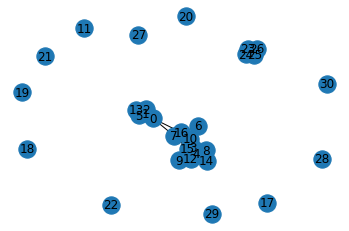

In [88]:
# plot the new data in a network, droping the object type features and the old Month/Day/DayWeek/DepTime/ArrTime/CRS
dfnum=df[['ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Distance', 
          'TaxiIn', 'TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 
          'VelocityAir', 'DelayedArr', 'TotalDelayed', 'TaxiTime', 'Msin', 'Mcos', 'Dsin', 'Dcos', 'Wsin', 'Wcos',
          'DateDep', 'DateCRSDep', 'DateArr', 'DateCRSArr','UCarrier_en', 'Origin_en', 'Dest_en', 'TailNum_en']]

# 1. get adjacency matrix
corrdf = dfnum.corr()
corrdfas = abs(corrdf)

# 2. Use a threshold to only keep the strongest links:
thres = corrdfas.std()
net = corrdf[(corrdf >= thres) & (corrdf != 1) ] # we don't want self links.
net[np.isnan(net)] = 0
net2 = np.array(net)

# Relabel nodes:
#mapping = dict(zip(G, dfnum.columns.to_list())) # if we want to insert the column name.

# 3. Map the network
G = nx.from_numpy_matrix(net2)

pos = nx.spring_layout(G)
nodes = nx.draw_networkx_labels(G, pos)

nx.draw(G, pos)
plt.show()

In [89]:
dict(zip(G, dfnum.columns.to_list()))

{0: 'ActualElapsedTime',
 1: 'CRSElapsedTime',
 2: 'AirTime',
 3: 'ArrDelay',
 4: 'DepDelay',
 5: 'Distance',
 6: 'TaxiIn',
 7: 'TaxiOut',
 8: 'CarrierDelay',
 9: 'WeatherDelay',
 10: 'NASDelay',
 11: 'SecurityDelay',
 12: 'LateAircraftDelay',
 13: 'VelocityAir',
 14: 'DelayedArr',
 15: 'TotalDelayed',
 16: 'TaxiTime',
 17: 'Msin',
 18: 'Mcos',
 19: 'Dsin',
 20: 'Dcos',
 21: 'Wsin',
 22: 'Wcos',
 23: 'DateDep',
 24: 'DateCRSDep',
 25: 'DateArr',
 26: 'DateCRSArr',
 27: 'UCarrier_en',
 28: 'Origin_en',
 29: 'Dest_en',
 30: 'TailNum_en'}

The principal network is done by the nodes from 0 to 16 (ActualElapsedTime-TaxiTime), but 11 (SecurityDelay). They are the same ones we have found in exercise 1 to be the principals to the determination of the delays.
The second network we see are the one with the nodes 23 to 26 (DateDep-DateCRSArr), as before we saw on exercise 1, the times of these nodes are correlated, and since we have simply applied some multiplications and sums of the dates columns, the correlations are mantained. The nodes that are not linked to any of the others correspond to: 
1. Dates in polars coordinates (nodes 17 to 20), in this case we have done a polar transformation to each feature independently, they were not correlated to any each other before the transformation, they mantain the independence.
2. UniqueCarrier, Origin, Destination, are independents to other variables. The transformation had only remapped the different values from string to numerical, and in the graph we can see that they are not correlated to the variables related to the delays.

So, for the next transformation, we will drop these variables and use the same ones of the exercise 1, that are nodes from the largest network, 0 to 16, but 11.

We also notice, that nodes 0 to 16 are not categorical.

In [90]:
df3 = df[['ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Distance', 
          'TaxiIn', 'TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 
          'VelocityAir', 'DelayedArr', 'TotalDelayed', 'TaxiTime']]

In [91]:
X2 = np.array(df3.drop('ArrDelay', axis=1))
y2 = np.array(df3.ArrDelay)

In [93]:
# use a StandardScaler
scaler1 = StandardScaler()
X_scaled = scaler1.fit_transform(X2) 

In [94]:
# use robust scaler
scaler2 = RobustScaler()
X_scaled2 = scaler2.fit_transform(X2)

In [96]:
X2a_train, X2a_test, y2a_train, y2a_test = train_test_split(X_scaled, y2.ravel(), 
                                                        test_size=0.3, random_state=42, shuffle=True)
X2b_train, X2b_test, y2b_train, y2b_test = train_test_split(X_scaled2, y2.ravel(), 
                                                        test_size=0.3, random_state=42, shuffle=True)

In [101]:
# to make a quick study of these two transformation and see if one performs better than the other we will make
# use LinearRegression to see the difference between X_scaled and X_scaled2

# StandardScaled:
mLR1 = LinearRegression(n_jobs=-1)
mLR1.fit(X2a_train, y2a_train)

y2apred = mLR1.predict(X2a_test)
print('Determination coefficient train Scaled: ', mLR1.score(X2a_train,y2a_train))
print('Determination coefficient test Scaled: ', mLR1.score(X2a_test,y2a_test))
print('Mean Squared Error Scaled: ', metrics.mean_squared_error(y2a_test, y2apred))
print('Mean Absolute Error Scaled: ', metrics.mean_absolute_error(y2a_test, y2apred))
print('\n')

# RobustScaled:
mLR2 = LinearRegression(n_jobs=-1)
mLR2.fit(X2b_train, y2b_train)

y2bpred = mLR2.predict(X2b_test)
print('Determination coefficient train Robust: ', mLR2.score(X2b_train,y2b_train))
print('Determination coefficient test Robust: ', mLR2.score(X2b_test,y2b_test))
print('Mean Squared Error Robust: ', metrics.mean_squared_error(y2b_test, y2bpred))
print('Mean Absolute Error Robust: ', metrics.mean_absolute_error(y2b_test, y2bpred))
print('\n')

print('DeterminationCoefficient train difference:', abs(mLR1.score(X2a_train,y2a_train) - mLR2.score(X2b_train,y2b_train)))
print('DeterminationCoefficient test difference:', abs(mLR1.score(X2a_test,y2a_test)- mLR2.score(X2b_test,y2b_test)))
print('MeanSquaredError difference:', abs(metrics.mean_squared_error(y2a_test, y2apred) - metrics.mean_squared_error(y2b_test, y2bpred)))
print('MeanAbsolutError difference:', abs( metrics.mean_absolute_error(y2a_test, y2apred) - metrics.mean_absolute_error(y2b_test, y2bpred)))


Determination coefficient train Scaled:  0.9999999979397343
Determination coefficient test Scaled:  0.9999999983780555
Mean Squared Error Scaled:  5.1857381736750264e-06
Mean Absolute Error Scaled:  1.1377533427605697e-05


Determination coefficient train Robust:  0.9999999979397343
Determination coefficient test Robust:  0.9999999983780556
Mean Squared Error Robust:  5.185737881703653e-06
Mean Absolute Error Robust:  1.1369265182414033e-05


DeterminationCoefficient train difference: 0.0
DeterminationCoefficient test difference: 1.1102230246251565e-16
MeanSquaredError difference: 2.9197137346319334e-13
MeanAbsolutError difference: 8.268245191664386e-09


In this dataset there is no difference by using a standardscaler or a robustscaler in order to standarize the dataset. We can choose to use either if we want to standarize the dataset.

# Nivell 3

## Exercici 6: No utilitzis la variable *DepDelay* a l’hora de fer prediccions

In this exercise to make it a bit more challeging for the model to calculate the ArrDelay column. To do so, we will sustract the column DepDelay and mantain all column **but** the DelayedArr (binary column that indicates with 0 or 1 if there has been a delay) will also be sustracted when using the model LinearRegression, since over all three methods this one is the one that it is more well behave when we want to predict the minutes of a plane that has been late.

Remember that TotalDelayed is the sum of: CarrierDelay, WeatherDelay, NASDelay, SecurityDelay and LateAircraftDelay.
It contains more of the information to have a well behaved prediction, also, the other two columns that contain most of the information into having a well behaved fit are: ActualElapsedTime/CRSElapsedTime.


In [27]:
df4 = df[['ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'Distance', 
          'TaxiIn', 'TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay', 'VelocityAir', 
          'TotalDelayed']]

In [28]:
df4.shape

(1928368, 13)

In [29]:
X2 = np.array(df4.drop('ArrDelay', axis=1))
y2 = np.array(df4.ArrDelay)

In [30]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2.ravel(), test_size=0.3,random_state=42, shuffle=True)

We make use of the default parameters in each one of the models, since they had given us better fitting, and more well behaved predictions, than the ones obtained when we have reavaluated the parameters.

**Linear Regression**

In [43]:
mLR = LinearRegression(n_jobs=-1)
mLR.fit(X2_train, y2_train)

LinearRegression()

In [42]:
y2predLR = mLR.predict(X2_test)

print('Determination coefficient train: ', mLR.score(X2_train,y2_train))
print('Determination coefficient test: ', mLR.score(X2_test,y2_test))
print('Mean Squared Error: ', metrics.mean_squared_error(y2_test, y2predLR))
print('Mean Absolute Error: ', metrics.mean_absolute_error(y2_test, y2predLR))

Determination coefficient train:  0.9930680566357558
Determination coefficient test:  0.992954781893624
Mean Squared Error:  22.52522106609249
Mean Absolute Error:  3.207773887048292


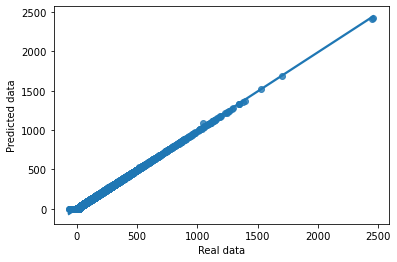

In [39]:
# graph
df2LR = pd.DataFrame({'Real': y2_test, 'Predicted': y2predLR})
sns.regplot(data=df2LR, x='Real', y='Predicted')
plt.xlabel('Real data')
plt.ylabel('Predicted data')
plt.show()

In [44]:
df2LR

,Real,Predicted
0,15.0,17.331247
1,9.0,0.008318
2,14.0,1.784410
3,81.0,80.460367
4,19.0,21.905668
...,...,...
578506,96.0,96.365438
578507,118.0,117.567137
578508,7.0,1.943952
578509,-4.0,1.605417


Without the DepDelay and DelayedArr features we can see that the error (absolute and squared) had increased but the predicted data is overall still well behaved as we can see in the graph above and with the determination coefficient. But on a insight on each one of the predicted values vs real values we can see that not very well predicted, as it is shown in the graph below.

In the graph below, we plot one-on-one a subsample of the values predicted and real, and on doing so, we can see that not adding DelayedArr has made that planes that are on time or earlier now have delay, as it is the case of num row: 509850. To get more accurate prediction it is indispensable that the dataset contains the column DelayedArr. 

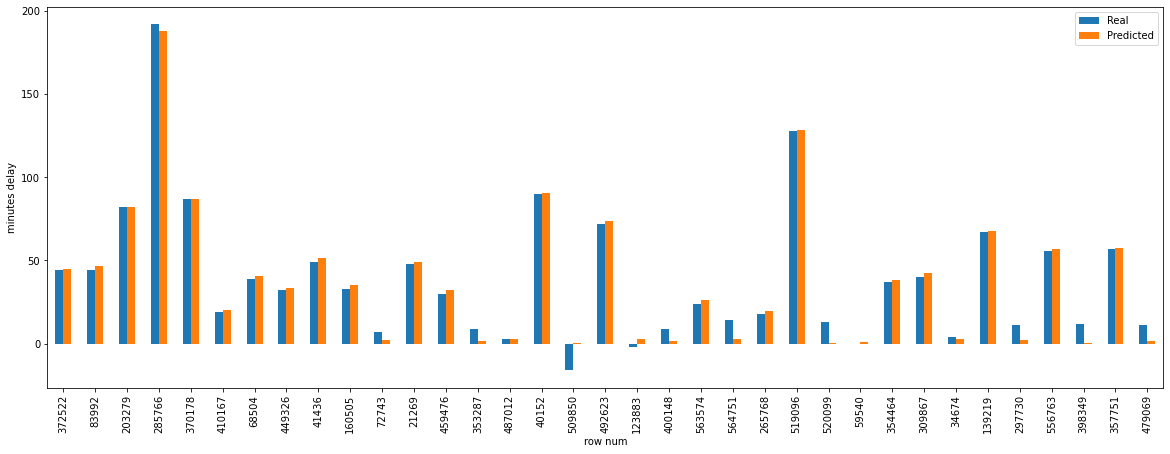

In [48]:
# we use to do this graph only 35 entries:
df2LRp = df2LR.sample(35)
df2LRp.plot(kind='bar',figsize=(20,7))
plt.xlabel('row num')
plt.ylabel('minutes delay')
plt.show()

**Decision Tree Regressor**

For this model we will add the column DelayedArr to see if we have a better prediction than we had got with LinearRegression.

In [49]:
df4 = df[['ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'Distance', 
          'TaxiIn', 'TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay', 'VelocityAir', 
          'DelayedArr', 'TotalDelayed']]

In [50]:
X2 = np.array(df4.drop('ArrDelay', axis=1))
y2 = np.array(df4.ArrDelay)

In [51]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2.ravel(), test_size=0.3,random_state=42, shuffle=True)

In [52]:
mDT = DecisionTreeRegressor(random_state = 42)
mDT.fit(X2_train, y2_train)

DecisionTreeRegressor(random_state=42)

In [54]:
np.round(mDT.feature_importances_, 3)

array([0.001, 0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.004, 0.993])

Since we don't have DepDelay anymore the feature that has more weight in the prediction now is the made out column: TotalDelayed, since tells us how many minutes the plane will depart late, thus will arrive late on the destination, followed by the column DelayedArr.

In [55]:
y2predDT = mDT.predict(X2_test)

print('Determination coefficient train: ', mDT.score(X2_train,y2_train))
print('Determination coefficient test: ', mDT.score(X2_test,y2_test))
print('Mean Squared Error: ', metrics.mean_squared_error(y2_test, y2predDT))
print('Mean Absolute Error: ', metrics.mean_absolute_error(y2_test, y2predDT))

Determination coefficient train:  0.9999350283292258
Determination coefficient test:  0.995753563755072
Mean Squared Error:  13.576856488446236
Mean Absolute Error:  1.4295958460642884


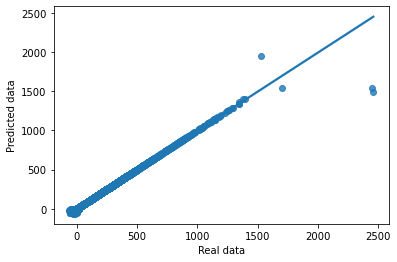

In [56]:
# graph
df2DT = pd.DataFrame({'Real': y2_test, 'Predicted': y2predDT})
sns.regplot(data=df2DT, x='Real', y='Predicted')
plt.xlabel('Real data')
plt.ylabel('Predicted data')
plt.show()

Absolute and Squared error had increased in both cases, also the determination coefficients are lower than before sustracting DepDelay. We also notice, in the graph above, that the delays with more minutes of delay (higher values) are not well predicted. Also, there is a bit of misprediction on values around zero to 500 minutes of delay.

Taking a look at the data (table below and graph below), we can see that now since we have added the DelayedArr column (binary 0 for on time/earlier and 1 for late), we are able to predict more accurately which planes are actually late and which are non late. For example, now the plane row number: 466028, is marked as earlier arrival although the actual number of minutes that it is earlier is a little off. In this graph below we can see that are the predictor has problems in correctly predicting values under 50 minutes of delay.

Overall the predictions are more well behaved than when we have sustracted the feature DelayedArr, but not than finer as they could have been if we had the feature DepDelay.

In [57]:
df2DT

,Real,Predicted
0,15.0,15.0
1,9.0,2.0
2,14.0,8.0
3,81.0,81.0
4,19.0,19.0
...,...,...
578506,96.0,96.0
578507,118.0,118.0
578508,7.0,9.0
578509,-4.0,-4.0


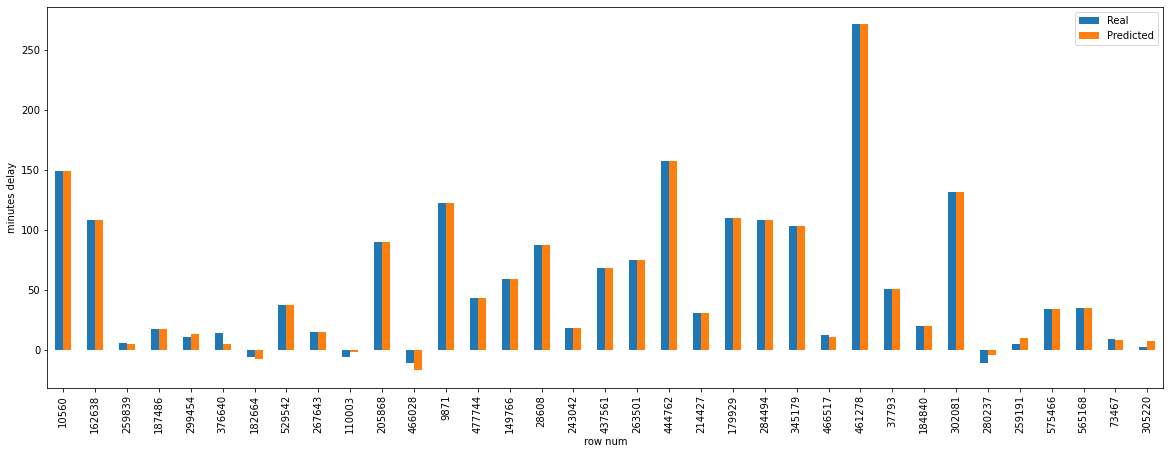

In [58]:
# we use to do this graph only 35 entries:
df2DTp = df2DT.sample(35)
df2DTp.plot(kind='bar',figsize=(20,7))
plt.xlabel('row num')
plt.ylabel('minutes delay')
plt.show()

**Random Forest Regressor**

In [59]:
mRF = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
mRF.fit(X2_train, y2_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [60]:
y2predRF = mRF.predict(X2_test)

print('Determination coefficient train: ', mRF.score(X2_train,y2_train))
print('Determination coefficient test: ', mRF.score(X2_test,y2_test))
print('Mean Squared Error: ', metrics.mean_squared_error(y2_test, y2predRF))
print('Mean Absolute Error: ', metrics.mean_absolute_error(y2_test, y2predRF))

Determination coefficient train:  0.9997064244992002
Determination coefficient test:  0.9976235556974111
Mean Squared Error:  7.598051963589911
Mean Absolute Error:  1.1149124927121354


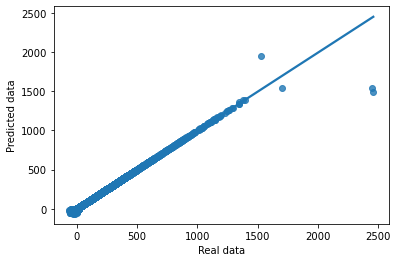

In [61]:
# graph
df2RF = pd.DataFrame({'Real': y2_test, 'Predicted': y2predRF})
sns.regplot(data=df2DT, x='Real', y='Predicted')
plt.xlabel('Real data')
plt.ylabel('Predicted data')
plt.show()

Like in both previous cases, the squared and the absolute error had increase, also the determination coeffiecient had slightly decrease, which indicates that the model may have a bit more of error when predicts the minutes of arrival when the plane is delayed.

In the graph above we can see that the same artifact when the number of minutes are high and small, from zero to 500 minutes, the model cannot predict very well its values. But for small values below 1500 minutes the predictions and around zero minutes of delay that the model has can predict them finer, thus the model it is well behaved. 

In the table below and in the graph below, we see that there are accurated predictions for values around 50 minutes of delay and higher, that the DelayedArr has helped to determine which values are actually late and which are on time/earlier, and the discrepances in the predicted values, in this subsample of data only occur in the values below 50 minutes of delay or early arrivals. As we have seen this artifact happening with DecisionTreeRegressor.

In [62]:
df2RF

,Real,Predicted
0,15.0,15.00
1,9.0,6.77
2,14.0,6.70
3,81.0,81.00
4,19.0,19.00
...,...,...
578506,96.0,96.00
578507,118.0,118.00
578508,7.0,5.36
578509,-4.0,-3.13


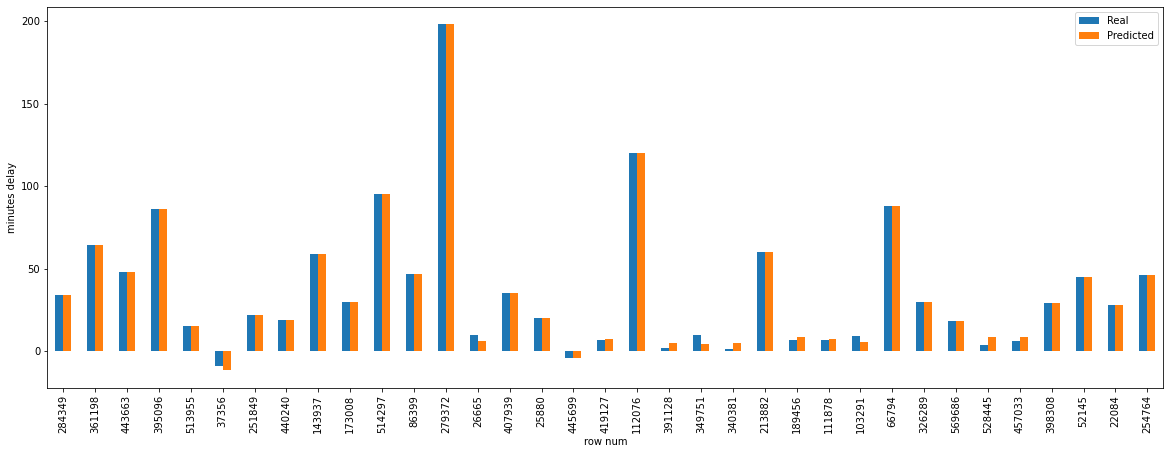

In [63]:
# we use to do this graph only 35 entries:
df2RFp = df2RF.sample(35)
df2RFp.plot(kind='bar',figsize=(20,7))
plt.xlabel('row num')
plt.ylabel('minutes delay')
plt.show()